In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TabNet: Attentive Interpretable Tabular Learning

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ml-on-gcp/blob/master/tutorials/explanations/ai-explanations-tabnet-algorithm.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ml-on-gcp/tree/main/tutorials/explanations/ai-explanations-tabnet-algorithm.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

## Overview

AI Platform provides a built-in algorithm based on [TabNet](https://arxiv.org/abs/1908.07442).

Learn how to [train and deploy a model with the TabNet built-in algorithm](https://cloud.google.com/ai-platform/training/docs/algorithms/tab-net-start).

This tutorial provides the sample code to visualize the explanation of TabNet algorithm with Synthetic_2 (Syn2) data.

Syn2 data is described at [Section 4.1 of learning to explain paper](https://arxiv.org/pdf/1802.07814.pdf). The input feature X is generated from a 10-dimensional standard Gaussian. The response variable Y is generated from feature X[3:6] only.

### Objective

The goal is to provide a sample plotting tool to visualize the output of TabNet, which is helpful in explaining the algorithm.

## Before you begin

Make sure you're running this notebook in a **GPU runtime** if you have that option. In Colab, select **Runtime** --> **Change runtime type**


This tutorial assumes you are running the notebook either in **Colab** or **Cloud AI Platform Notebooks**.

### Set up your GCP project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a GCP project.](https://console.cloud.google.com/cloud-resource-manager)

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the AI Platform Training & Prediction and Compute Engine APIs.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component)

4. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

In [ ]:
PROJECT_ID = "[<your-project-id>]"

### Authenticate your GCP account

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

In [ ]:
import os
import sys
import warnings

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# If you are running this notebook in Colab, follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.


def install_dlvm_packages():
    !pip install tabulate


if 'google.colab' in sys.modules:
    from google.colab import auth as google_auth
    google_auth.authenticate_user()
    !pip install witwidget --quiet
    !pip install tensorflow==1.15.0 --quiet
    !gcloud config set project $PROJECT_ID


elif "DL_PATH" in os.environ:
    install_dlvm_packages()

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. AI Platform runs
the code from this package. In this tutorial, AI Platform also saves the
trained model that results from your job in the same bucket. You can then
create an AI Platform model version based on this output in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets. 

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Cloud
AI Platform services are
available](https://cloud.google.com/ml-engine/docs/tensorflow/regions). You may
not use a Multi-Regional Storage bucket for training with AI Platform.

In [1]:
BUCKET_NAME = "[<your-bucket-name>]"
REGION = "us-central1"

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
!gsutil mb -l $REGION gs://$BUCKET_NAME

### Import libraries

Import the libraries we'll be using in this tutorial. 

In [2]:
import numpy as np
import json
from google.cloud import storage
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

## Reading a sample TabNet prediction on syn2 data

After training and serving your model, you upload the output to Google Cloud Storage. There is a sample TabNet prediction using synthetic data: gs://cloud-samples-data/ai-platform/synthetic/tab_net_output/syn2

You can copy this output to your bucket for testing. Running prediction on your own data will generate the output having the same format.

Each prediction in TabNet contains **aggregated_mask_values** field. The masks are used to explain the predictions. 


In [3]:
!gsutil cp gs://cloud-samples-data/ai-platform/synthetic/tab_net_output/syn2 gs://$BUCKET_NAME

# Replace your the BUCKET_NAME and PREDICTION_FILE
# BUCKET_NAME = "[<your-bucket-name>]"
# PREDICTION_FILE = "[<your-prediction-file>]"

PREDICTION_FILE = "syn2"

MASK_KEY = "aggregated_mask_values"

HEADER = [("feat_" + str(i)) for i in range(1, 12)]
HEADER

Copying gs://cloud-samples-data/ai-platform/synthetic/tab_net_output/syn2 [Content-Type=text/plain]...
/ [1 files][  2.2 MiB/  2.2 MiB]                                                
Operation completed over 1 objects/2.2 MiB.                                      


['feat_1',
 'feat_2',
 'feat_3',
 'feat_4',
 'feat_5',
 'feat_6',
 'feat_7',
 'feat_8',
 'feat_9',
 'feat_10',
 'feat_11']

### Download and preprocess the predictions.

In [4]:
storage_client = storage.Client()
bucket = storage_client.get_bucket(BUCKET_NAME)
blob = bucket.blob(PREDICTION_FILE)
f = blob.download_as_string(client=None).decode("utf-8").strip()
predictions = f.split("\n")
predictions[:1]

/usr/local/google/home/longtle/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/google/home/longtle/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.

['{"predicted_classes": [0], "logits": [-1.6054713726043701], "aggregated_mask_values": [0.0, 0.0, 1.1298394203186035, 0.8574417233467102, 0.3952142894268036, 2.4348602294921875, 0.5338992476463318, 0.0, 0.0, 0.0, 0.0], "key": ["2"]}']

### Parse the mask values in prediction. Then, concatenate the mask values.
The output is a matrix having Nxk (N is the number of outputs, k is the size of each mask).
Concatenating mask values are used to visualize the feature importance.

In [5]:
masks = []
for prediction in predictions:
    prediction = json.loads(prediction)
    masks.append(prediction[MASK_KEY])
masks = np.matrix(masks)
masks.shape

(10000, 11)

## Visualize the mask value matrix. 
The lighter color indicates more important feature.
For example, only features 3-6 are meaningful in prediction output in Syn2 data. In the plot, the column 3-6 have light color.

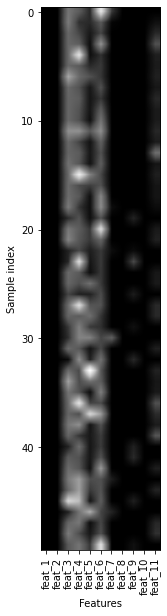

In [6]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121)
ax.imshow(masks[:50, :], interpolation='bilinear', cmap=cm.Greys_r)
ax.set_xlabel('Features')
ax.set_ylabel('Sample index')
ax.xaxis.set_ticks(np.arange(len(HEADER)))
ax.set_xticklabels(HEADER, rotation='vertical')
plt.show()

If your Cloud Storage bucket doesn't contain any other objects and you would like to delete it, run `gsutil rm -r gs://$BUCKET_NAME`.

## What's next?

To learn more about TabNet, check out the resources here.

* [TabNet: Attentive Interpretable Tabular Learning](https://arxiv.org/abs/1908.07442)
* [https://arxiv.org/abs/1908.07442](https://cloud.google.com/ai-platform/training/docs/algorithms?hl=en) 